In [1]:
import os
import sys
import glob
import glob
import xesmf as xe
import numpy as np
import xarray as xr
import pandas as pd
from pathlib import Path
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
project_root = Path.cwd().parent  
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))
from src.utils.utils import data_split
import matplotlib.dates as mdates

# Get Static Parameters

In [2]:
static = xr.open_dataset('/bsuscratch/stanleyakor/uppercolorado/static_inputs/wrfout_d02_2000-04-08_00:00:00').isel(Time = 0)

lat = static.XLAT.values[:,0]
lon = static.XLONG.values[0,:]

# Get Data Paths

In [3]:

path_atmos_only = '../data/WRF_v1_PREDICTION.nc'
path_atmos_static ='../data/WRF_STATIC_v1_PREDICTION.nc'
path_all_features = '../data/WRF_MODIS_STATIC_v2_PREDITICTION.nc'



# Evaluate Emulated SWE

In [4]:
start = '2015-10-06'
end = '2016-09-30'

wy_2016_true = data_split('2016','2016').sel(XTIME = slice(start, end)) # true swe: naoh-mp

data_all_features = xr.open_dataset(path_all_features) 
data_atmos = xr.open_dataset(path_atmos_only)
data_atmos_static= xr.open_dataset(path_atmos_static)


In [5]:
all_features  = data_all_features['SNOW'].mean(dim=('south_north', 'west_east'))
noah_np_spatial_mean = wy_2016_true['SNOW'].mean(dim=('south_north', 'west_east'))

atmos_only  = data_atmos['SNOW'].mean(dim=('south_north', 'west_east'))
atmos_static = data_atmos_static['SNOW'].mean(dim=('south_north', 'west_east'))

In [6]:
wy_2016_true = data_split('2016','2016').sel(XTIME = slice(start, end)) # true swe: naoh-mp

data_all_features = xr.open_dataset(path_all_features) 
data_atmos = xr.open_dataset(path_atmos_only)
data_atmos_static= xr.open_dataset(path_atmos_static)

elevation_data = xr.open_dataset('/bsuscratch/stanleyakor/uppercolorado/static_inputs/wrfout_d02_2000-04-08_00:00:00').isel(Time = 0)

In [7]:
def plot_model_comparison(noah, atmos, atmos_static, all_features, elevation_data,
                          start_date='2015-10-06', end_date='2016-09-30',
                          output_file='x.pdf'):
    """
    Compare SWE (or snow variable) between Noah-MP and multiple emulator setups.
    Layout:
      Row 1: All grid points
      Row 2: High elevation (≥2500 m)
      Columns: Atmospheric only | Atmos + Static | All Features
    """

    # --- Extract SWE variable ---
    snow_noah = noah['SNOW'].sel(XTIME=slice(start_date, end_date))
    all_feat = all_features['SNOW'].sel(XTIME=slice(start_date, end_date))
    atmos_feat = atmos['SNOW'].sel(XTIME=slice(start_date, end_date))
    atmos_static_feat = atmos_static['SNOW'].sel(XTIME=slice(start_date, end_date))

    # --- Ensure common time alignment ---
    common_time = np.intersect1d(
        np.intersect1d(np.intersect1d(snow_noah['XTIME'], all_feat['XTIME']),
                       atmos_feat['XTIME']),
        atmos_static_feat['XTIME']
    )

    snow_noah = snow_noah.sel(XTIME=common_time)
    all_feat = all_feat.sel(XTIME=common_time)
    atmos_feat = atmos_feat.sel(XTIME=common_time)
    atmos_static_feat = atmos_static_feat.sel(XTIME=common_time)

    # --- Elevation mask ---
    elev = elevation_data['HGT']
    high_elev_mask = elev >= 2500

    # --- Compute spatial means ---
    def mean_vals(snow_field):
        """Return mean for all grid points and for high elevation."""
        mean_all = snow_field.mean(dim=('south_north', 'west_east'))
        mean_high = snow_field.where(high_elev_mask).mean(dim=('south_north', 'west_east'))
        return mean_all, mean_high

    mean_noah_all, mean_noah_high = mean_vals(snow_noah)
    mean_atmos_all, mean_atmos_high = mean_vals(atmos_feat)
    mean_atmos_static_all, mean_atmos_static_high = mean_vals(atmos_static_feat)
    mean_all_feat_all, mean_all_feat_high = mean_vals(all_feat)

    # --- Setup plotting ---
    fig, axes = plt.subplots(2, 3, figsize=(16, 6), constrained_layout=True)
    configs = [
        ('Model 1', mean_atmos_all, mean_atmos_high), # WRF forcings only
        ('Model 2', mean_atmos_static_all, mean_atmos_static_high), # WRF and static forcings
        ('Model 3', mean_all_feat_all, mean_all_feat_high) # WRF, static and remotely sensed data
    ]
    colors = ['tab:green', 'tab:orange', 'tab:red']

    # --- Plot comparisons ---
    for i, (label, mean_all, mean_high) in enumerate(configs):
        # Row 1: All grid points
        axes[0, i].plot(mean_noah_all['XTIME'], mean_noah_all, color='black', linewidth=2, label='Noah-MP')
        axes[0, i].plot(mean_all['XTIME'], mean_all, color=colors[i], linewidth=2, label=label)
        # axes[0, i].set_title(f'{label}\n(All Elevations)', fontsize=10)
        axes[0, i].grid(True, linestyle='--', alpha=0.4)
        if i == 0:
            axes[0, i].set_ylabel('SWE (mm)')
        axes[0, i].legend(fontsize=8)

        # Row 2: High elevation
        axes[1, i].plot(mean_noah_high['XTIME'], mean_noah_high, color='black', linewidth=2, label='Noah-MP')
        axes[1, i].plot(mean_high['XTIME'], mean_high, color=colors[i], linewidth=2, label=label)
        # axes[1, i].set_title(f'{label}\n(≥2500 m)', fontsize=10)
        axes[1, i].grid(True, linestyle='--', alpha=0.4)
        if i == 0:
            axes[1, i].set_ylabel('SWE (mm)')
        axes[1, i].legend(fontsize=8)

    # for ax in axes.flat:
        # ax.set_xlabel('Time')
        # ax.tick_params(axis='x', rotation=30)

    # Label subplot panels (a–f)
    panel_labels = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)']
    for ax, label in zip(axes.flat, panel_labels):
        ax.text(0.02, 0.88, label, transform=ax.transAxes, fontsize=10, weight='bold')

    plt.savefig(output_file, dpi=300, bbox_inches='tight')
    plt.show()


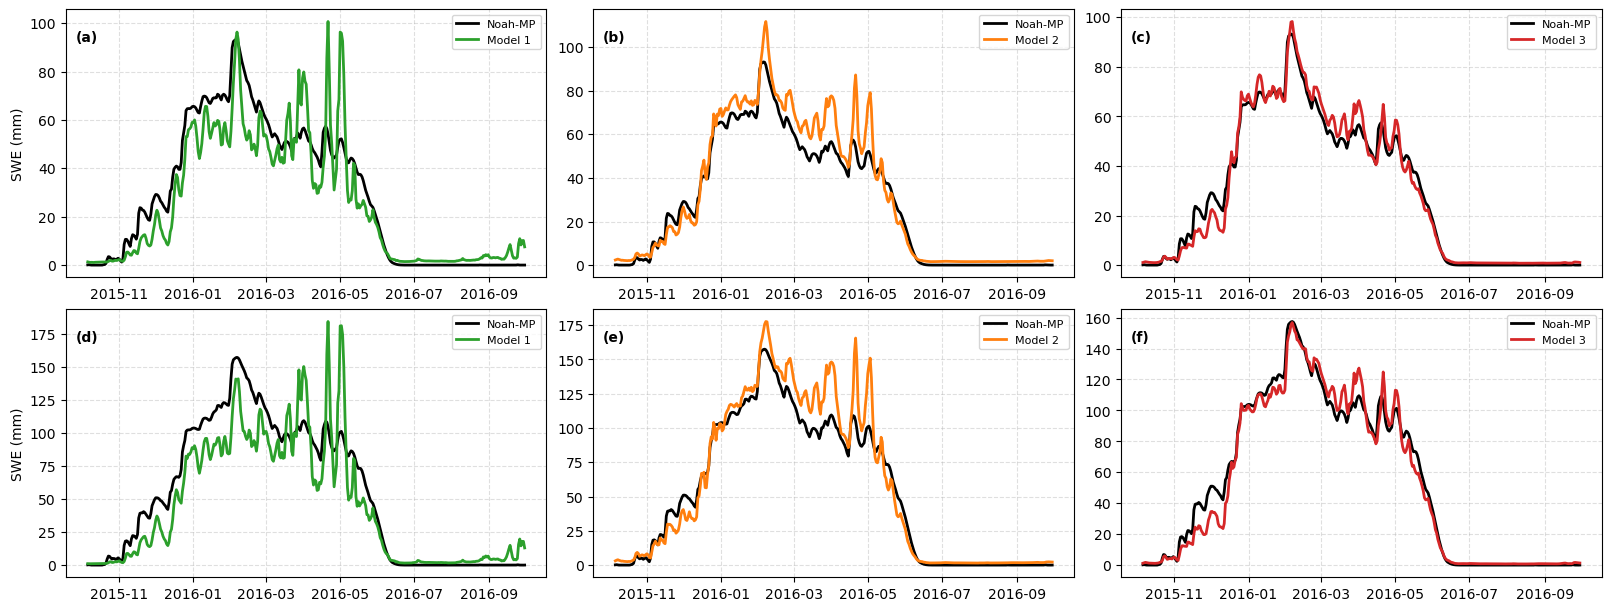

In [8]:
plot_model_comparison(wy_2016_true, data_atmos, data_atmos_static, data_all_features, elevation_data)